In [1]:
"""导入读取数据的包"""
import numpy as np
import pandas as pd

In [2]:
"""导入画图的包"""
import matplotlib.pyplot as plt
from matplotlib import rcParams
#from matplotlib.cm import rainbow
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']    #用来正常显示中文标签

In [3]:
"""导入警告的忽略处理"""
import warnings
warnings.filterwarnings('ignore')

In [4]:
"""导入sklearn中的一些函数"""
from sklearn.neighbors import KNeighborsClassifier    #K近邻分类（KNN）
from sklearn.tree import DecisionTreeClassifier    #决策树
from sklearn.linear_model import LogisticRegression    #逻辑斯特回归
from sklearn.model_selection import train_test_split    #数据划分
from sklearn.preprocessing import StandardScaler    #数据归一化处理
from sklearn.model_selection import GridSearchCV    #网格搜索
from sklearn import metrics
from sklearn.metrics import confusion_matrix    #导入混淆矩阵
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report    #分类指标报告
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [5]:
diabetes = pd.read_csv('diabetes.csv')    #导入数据
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
diabetes.info()    #查看数据集的有关信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
diabetes.describe()    #描述性统计

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
"""数据处理"""
#glucose、blood_pressure、skin_thick、insulin、BMI 最小数据不应为0，可理解这些数据列没有数据录入，存在数据缺失
#处理思路：1.将这些列的0值转换成NaN值；2.根据outcome的结果计算出各列的平均值；3.使用平均值填充缺失值。
# 更改列名为更好的理解和使用
diabetes.rename(columns={'Pregnancies': 'preg_times', 
                   'Glucose': 'glucose', 
                   'BloodPressure': 'blood_pressure', 
                   'SkinThickness': 'skin_thick', 
                   'Insulin': 'insulin',
                   'DiabetesPedigreeFunction': 'DPF',
                   'Age': 'age',
                   'Outcome': 'outcome'}, inplace=True) 
diabetes.head()

,preg_times,glucose,blood_pressure,skin_thick,insulin,BMI,DPF,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
# 数据清理 glucose、blood_pressure、skin_thick、insulin、BMI
# 存在无效的0值，将所有0值替换为NaN
diabetes_copy = diabetes.copy(deep = True)
diabetes_copy[['glucose', 'blood_pressure', 'skin_thick', 'insulin', 'BMI']] = \
diabetes_copy[['glucose', 'blood_pressure', 'skin_thick', 'insulin', 'BMI']].replace(0, np.NaN)
diabetes_copy.isnull().sum()

preg_times          0
glucose             5
blood_pressure     35
skin_thick        227
insulin           374
BMI                11
DPF                 0
age                 0
outcome             0
dtype: int64

In [10]:
# 填充缺失值
# 计算不同结果下各标签的平均值
def mea_byoutcome(index):
    temp = diabetes_copy[diabetes_copy[index].notnull()]
    temp = temp[[index, 'outcome']].groupby(['outcome'])[[index]].mean().reset_index()
    return temp

In [11]:
# 计算均值
mea_byoutcome('glucose')
mea_byoutcome('skin_thick')
mea_byoutcome('insulin')
mea_byoutcome('BMI')
mea_byoutcome('blood_pressure')

# 填充缺失值
diabetes_copy.loc[(diabetes_copy['outcome'] == 0) & (diabetes_copy['glucose'].isnull()), 'glucose'] = mea_byoutcome('glucose')['glucose'][0]
diabetes_copy.loc[(diabetes_copy['outcome'] == 1) & (diabetes_copy['glucose'].isnull()), 'glucose'] = mea_byoutcome('glucose')['glucose'][1]

diabetes_copy.loc[(diabetes_copy['outcome'] == 0) & (diabetes_copy['skin_thick'].isnull()), 'skin_thick'] = mea_byoutcome('skin_thick')['skin_thick'][0]
diabetes_copy.loc[(diabetes_copy['outcome'] == 1) & (diabetes_copy['skin_thick'].isnull()), 'skin_thick'] = mea_byoutcome('skin_thick')['skin_thick'][1]

diabetes_copy.loc[(diabetes_copy['outcome'] == 0) & (diabetes_copy['insulin'].isnull()), 'insulin'] = mea_byoutcome('insulin')['insulin'][0]
diabetes_copy.loc[(diabetes_copy['outcome'] == 1) & (diabetes_copy['insulin'].isnull()), 'insulin'] = mea_byoutcome('insulin')['insulin'][1]

diabetes_copy.loc[(diabetes_copy['outcome'] == 0) & (diabetes_copy['BMI'].isnull()), 'BMI'] = mea_byoutcome('BMI')['BMI'][0]
diabetes_copy.loc[(diabetes_copy['outcome'] == 1) & (diabetes_copy['BMI'].isnull()), 'BMI'] = mea_byoutcome('BMI')['BMI'][1]

diabetes_copy.loc[(diabetes_copy['outcome'] == 0) & (diabetes_copy['blood_pressure'].isnull()), 'blood_pressure'] = mea_byoutcome('blood_pressure')['blood_pressure'][0]
diabetes_copy.loc[(diabetes_copy['outcome'] == 1) & (diabetes_copy['blood_pressure'].isnull()), 'blood_pressure'] = mea_byoutcome('blood_pressure')['blood_pressure'][1]

# 填充后，确认是否存在缺失值
diabetes_copy.isnull().any()   

preg_times        False
glucose           False
blood_pressure    False
skin_thick        False
insulin           False
BMI               False
DPF               False
age               False
outcome           False
dtype: bool

In [12]:
diabetes_copy.describe()    #再次查看数据分布

,preg_times,glucose,blood_pressure,skin_thick,insulin,BMI,DPF,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000
mean,3.845052,121.697358,72.428141,29.247042,157.003527,32.44642,0.471876,33.240885,0.348958
std,3.369578,30.462008,12.106044,8.923908,88.860914,6.87897,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.20000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.50000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,130.287879,32.05000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,33.000000,206.846154,36.60000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.10000,2.420000,81.000000,1.000000


In [13]:
diabetes_copy[diabetes_copy['outcome'] == 0].describe()    # 没有患病组

,preg_times,glucose,blood_pressure,skin_thick,insulin,BMI,DPF,age,outcome
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000,0.0
std,3.017185,24.702314,11.927450,8.516280,74.400559,6.501303,0.299085,11.667655,0.0
min,0.000000,44.000000,24.000000,7.000000,15.000000,18.200000,0.078000,21.000000,0.0
25%,1.000000,93.000000,63.500000,22.000000,95.000000,25.750000,0.229750,23.000000,0.0
50%,2.000000,107.500000,70.877339,27.235457,130.287879,30.400000,0.336000,27.000000,0.0
75%,5.000000,125.000000,78.000000,31.000000,130.287879,35.300000,0.561750,37.000000,0.0
max,13.000000,197.000000,122.000000,60.000000,744.000000,57.300000,2.329000,81.000000,0.0


In [14]:
diabetes_copy[diabetes_copy['outcome'] == 1].describe()    # 患糖尿病组

,preg_times,glucose,blood_pressure,skin_thick,insulin,BMI,DPF,age,outcome
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.0
mean,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164,1.0
std,3.741239,29.488132,11.925638,8.456099,92.237987,6.590161,0.372354,10.968254,0.0
min,0.000000,78.000000,30.000000,7.000000,14.000000,22.900000,0.088000,21.000000,1.0
25%,1.750000,119.000000,68.000000,30.000000,175.000000,30.900000,0.262500,28.000000,1.0
50%,4.000000,140.500000,75.321429,33.000000,206.846154,34.300000,0.449000,36.000000,1.0
75%,8.000000,167.000000,82.000000,36.000000,206.846154,38.775000,0.728000,44.000000,1.0
max,17.000000,199.000000,114.000000,99.000000,846.000000,67.100000,2.420000,70.000000,1.0


患病率为 34.90 %


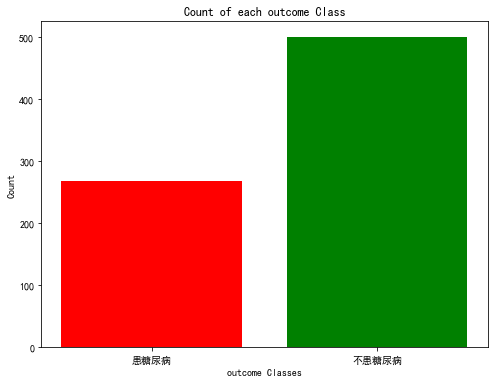

In [15]:
"""糖尿病患者分布状况"""
rcParams['figure.figsize'] = 8,6
x = diabetes['outcome'].unique()
y = diabetes['outcome'].value_counts()
label=['不患糖尿病','患糖尿病']
plt.bar(x,y, color = ['green','red' ])
plt.xticks(x,label)
plt.xlabel('outcome Classes')
plt.ylabel('Count')
plt.title('Count of each outcome Class')
print('患病率为 %.2f %%' % (diabetes.outcome.value_counts()[1] / diabetes.shape[0] * 100))

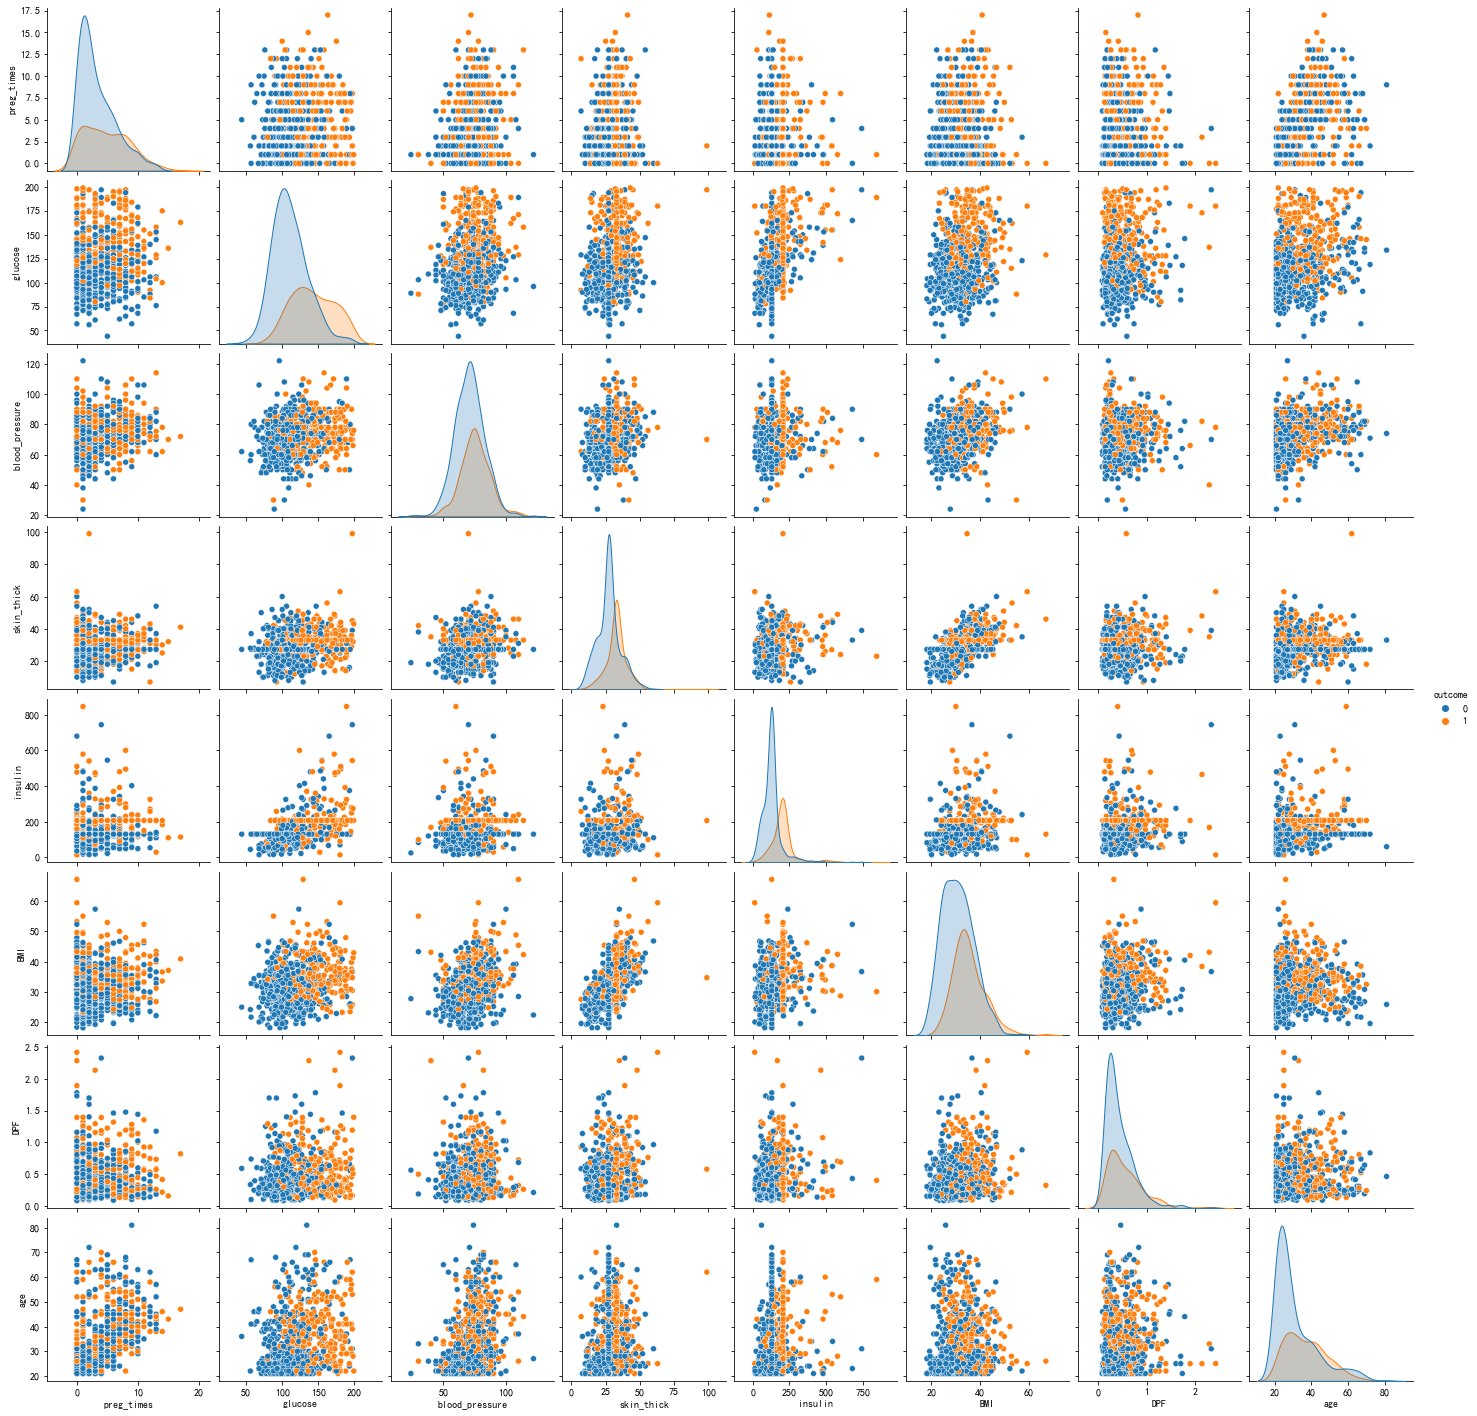

In [16]:
sns.pairplot(diabetes_copy, hue = 'outcome'); #以outcome为标准，可视化探索数据特征间的关系

In [17]:
corrdf = diabetes_copy.corr()
corrdf['outcome'].sort_values(ascending = False)
#相关性较强的前三参数是glucose、insulin、BMI，相关系数近似分别为0.495954、0.410918、0.315271。

outcome           1.000000
glucose           0.495954
insulin           0.410918
BMI               0.315271
skin_thick        0.308094
age               0.238356
preg_times        0.221898
blood_pressure    0.175087
DPF               0.173844
Name: outcome, dtype: float64

<AxesSubplot:>

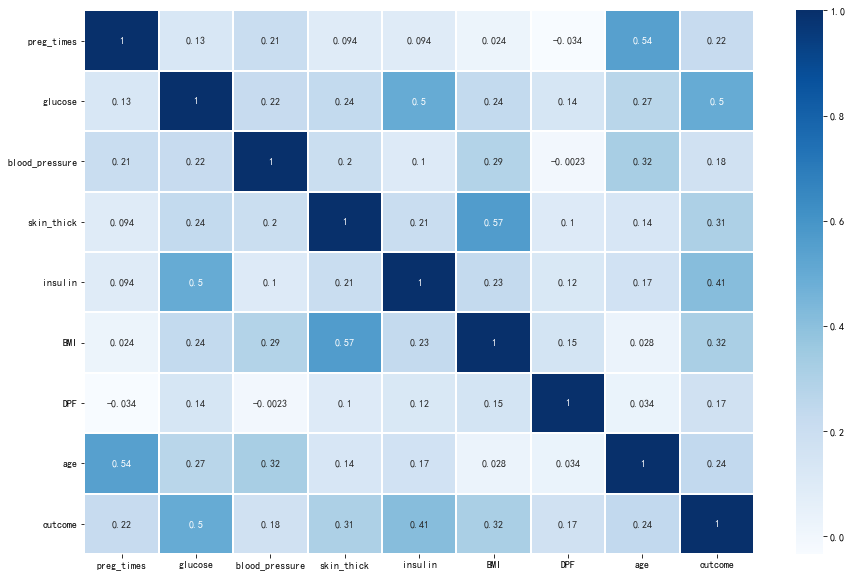

In [18]:
plt.figure(figsize=(15, 10), facecolor='w')
sns.heatmap(corrdf, vmax=1, square=False, annot=True, linewidth=1, cmap=plt.cm.Blues)

In [19]:
"""葡萄糖浓度和患糖尿病的相关性最强，研究葡萄糖与糖尿病之间的关系"""
Glucose_distDf = pd.DataFrame()    # 定义一个DataFrame接收分割后的葡萄糖浓度
Glucose_distDf['glucose_range']  = pd.cut(x = diabetes['glucose'],
                                  bins = [0,50,100,150,200],
                                  include_lowest = True,right=False,
                                  labels = ['[0-50)','[50-100)','[100-150)','[150-200)'])    # 用pd.cut() 将葡萄糖浓度进行分割
Glucose_distDf = pd.concat([Glucose_distDf['glucose_range'],diabetes['outcome']],axis=1)    # 将原数据集的Outcome合并到Glucose_distDf中
Glucose_distDf.head()

,glucose_range,outcome
0,[100-150),1
1,[50-100),0
2,[150-200),1
3,[50-100),0
4,[100-150),1


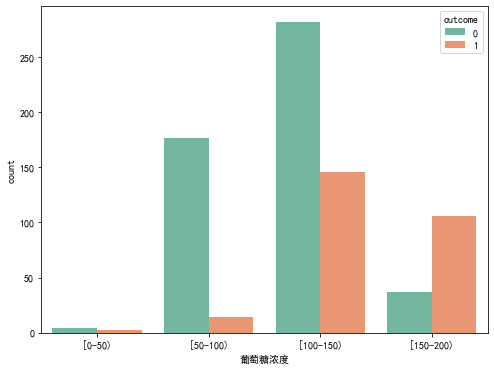

In [20]:
# 画柱状图，观察不同葡萄糖浓度的人患糖尿病的情况
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=Glucose_distDf,x='glucose_range',hue='outcome',palette='Set2')
plt.xlabel('葡萄糖浓度')
plt.show()
#结果显示这个数据中的患糖尿病人群主要集中在葡萄糖浓度大于100以上

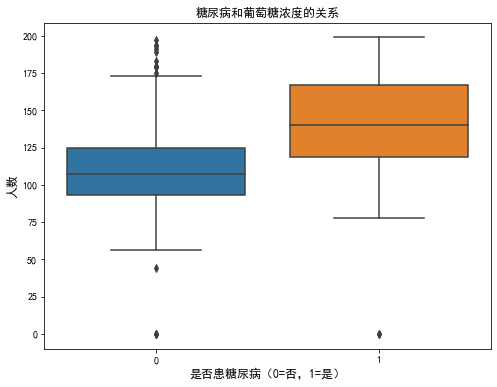

In [21]:
sns.boxplot(diabetes['outcome'],diabetes['glucose'])
plt.xlabel('是否患糖尿病（0=否，1=是）',fontsize=12)
plt.ylabel('人数',fontsize=12)
plt.title('糖尿病和葡萄糖浓度的关系')
plt.show()
#由图可以发现正常人的葡萄糖浓度是明显低于糖尿病患者的

In [22]:
"""研究年龄与糖尿病之间的关系"""
age_distDf = pd.DataFrame()    # 定义一个DataFrame接收分割后的年龄
age_distDf['age_range']  = pd.cut(x = diabetes['age'],
                                  bins = [0,18,40,60,100],
                                  include_lowest = True,right=False,
                                  labels = ['儿童','青年','中年','老年'])    # 用pd.cut() 将年龄进行分割
age_distDf = pd.concat([age_distDf['age_range'],diabetes['outcome']],axis=1)    # 将原数据集的Outcome合并到age_distDf中
age_distDf.head()

,age_range,outcome
0,中年,1
1,青年,0
2,青年,1
3,青年,0
4,青年,1


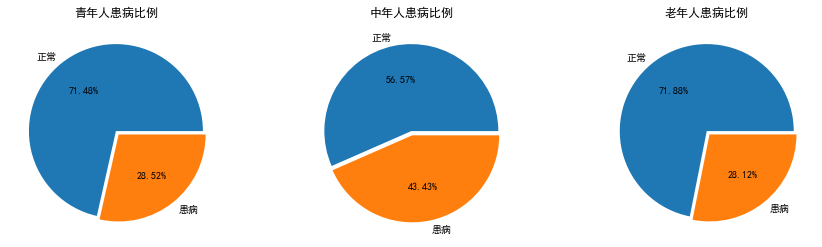

In [23]:
# 绘制饼图比较不同年龄段人群患病情况
plt.figure(figsize = (3*5,1*4))
# 青年人患病比例
ax1 = plt.subplot(1,3,1)
youth =  age_distDf[age_distDf['age_range']=='青年']['outcome'].value_counts()
plt.pie(youth,explode=[0,0.05],autopct='%.2f%%',labels=['正常','患病'])
plt.title('青年人患病比例')

# 中年人患病比例
ax2 =  plt.subplot(1,3,2)
middle = age_distDf[age_distDf['age_range']=='中年']['outcome'].value_counts()
plt.pie(middle,explode=(0,0.05),autopct='%.2f%%',labels=['正常','患病'])
plt.title('中年人患病比例')

# 老年人患病比例
ax2 = plt.subplot(1,3,3)
old =  age_distDf[age_distDf['age_range']=='老年']['outcome'].value_counts()
plt.pie(old,explode=[0,0.05],autopct='%.2f%%',labels=['正常','患病'])
plt.title('老年人患病比例')
plt.show()
#中年人的患病率高于青年人、老年人的患病率，很大程度上与现代中年人的不健康的生活习惯和工作应酬有关

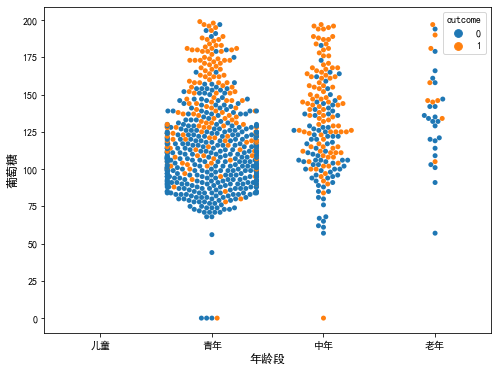

In [24]:
# 糖尿病和年龄也有一定的关系，可以结合考察糖尿病，葡糖糖浓度，年龄
data_Glucose= diabetes[['glucose','outcome']]
data_Glucose['age_range'] = pd.cut(diabetes['age'],bins=[0,18,40,60,100],
                           labels=['儿童','青年','中年','老年'],
                            include_lowest=True,right=False)
sns.swarmplot(data = data_Glucose,x= 'age_range',y='glucose', hue='outcome')
plt.xlabel('年龄段', fontsize=12)
plt.ylabel('葡萄糖',fontsize=12)
plt.show()
#同一年龄段，糖尿病人群的葡萄糖浓度普遍高于正常人
#调查对象主要为青年人，但患病群体（橙色点）主要集中在中年群体中

In [25]:
"""在对数据进行基本的统计描述之后，开始建立模型，预测分类结果"""
# 标准化数据
sc_X = StandardScaler()
source_x = pd.DataFrame(sc_X.fit_transform(diabetes_copy.drop(['outcome'], axis = 1),), columns = ['preg_times', 
                                                                                                   'glucose', 
                                                                                                   'blood_pressure', 
                                                                                                   'skin_thick', 
                                                                                                   'insulin',
                                                                                                   'BMI',
                                                                                                   'DPF',
                                                                                                   'age'])
source_x .head()

,preg_times,glucose,blood_pressure,skin_thick,insulin,BMI,DPF,age
0,0.639947,0.864020,-0.035389,0.645088,0.561272,0.167806,0.468492,1.425995
1,-0.844885,-1.205478,-0.531332,-0.027701,-0.300842,-0.850452,-0.365061,-0.190672
2,1.233880,2.013741,-0.696647,0.420825,0.561272,-1.330487,0.604397,-0.105584
3,-0.844885,-1.074081,-0.531332,-0.700491,-0.709475,-0.632253,-0.920763,-1.041549
4,-1.141852,0.502679,-2.680419,0.645088,0.123830,1.549727,5.484909,-0.020496


In [26]:
#分离数据标签
X = diabetes_copy.drop('outcome',axis=1)
y = diabetes_copy.outcome

In [27]:
#用 StandardScaler 对数据集中的特征进行区间化
standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [28]:
"""构建Logistic回归模型"""
log_reg= LogisticRegression()
log_reg.fit(X_train,y_train)    # 训练模型
log_pred_y = log_reg.predict(X_test)    # 预测数据
accuracy_score(y_test,log_pred_y)    # 导入评价指标，分类准确率

0.8051948051948052

In [29]:
#使用网格搜索寻找更好的模型参数
# 导入网格搜索
param_test =  {'penalty':['l2','l1'],
                'C':[0.01,0.1,1.0,10,100],
                'class_weight':[None,'balanced']}
log_gv =  GridSearchCV(estimator=log_reg,param_grid=param_test,cv=5)
log_gv.fit(X_train,y_train)
log_gv.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}

In [30]:
log_gv.score(X_test,y_test)    # 选取最优参数后，测试集得分

0.8376623376623377

In [31]:
log_pred_y =  log_gv.predict(X_test)    # 预测数据

In [32]:
print(classification_report(y_test,log_pred_y))    # 查看主要分类指标文本报告

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       107
           1       0.68      0.87      0.77        47

    accuracy                           0.84       154
   macro avg       0.81      0.85      0.82       154
weighted avg       0.86      0.84      0.84       154



In [33]:
"""构建KNN模型"""
from sklearn.neighbors import KNeighborsClassifier
knn =  KNeighborsClassifier()
knn.fit(X_train,y_train)
knn_pred_y = knn.predict(X_test)
knn.score(X_train,y_train)
knn.score(X_test,y_test)
accuracy_score(y_test,knn_pred_y)

0.8311688311688312

In [34]:
#使用网格搜索寻找更好的模型参数
from sklearn.model_selection import GridSearchCV
knn =  KNeighborsClassifier()
param_test =  [
    {'n_neighbors':[i for i in range(1,31)],
    'weights':['uniform']},

    {'n_neighbors':[i for i in range(1,21)],
    'weights':['distance'],
    'p':[i for i in range(1,6)]}
]
knn_gv = GridSearchCV(estimator = knn,param_grid=param_test,cv=5)
knn_gv.fit(X_train,y_train)
knn_gv.best_params_    # 输出最优参数

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [35]:
knn_gv.score(X_test,y_test)    # 选取最优参数后，测试集得分

0.8831168831168831

In [36]:
knn_pred_y = knn_gv.predict(X_test)    # 预测数据

In [37]:
print(classification_report(y_test,knn_pred_y))    # 查看主要分类指标文本报告

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       107
           1       0.80      0.83      0.81        47

    accuracy                           0.88       154
   macro avg       0.86      0.87      0.86       154
weighted avg       0.88      0.88      0.88       154



In [38]:
"""构建决策树模型"""
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)    # 训练数据
dt_pred_y = tree.predict(X_test)    # 预测数据
accuracy_score(y_test,dt_pred_y)    # 评估模型

0.8571428571428571

In [39]:
#使用网格搜索寻找更好的参数
param_test={'max_features':['auto','sqrt','log2'],
            'min_samples_split':list(range(2,20)),
            'min_samples_leaf':list(range(1,12))
}
tree_gv = GridSearchCV(estimator=tree,param_grid=param_test,cv=5)
tree_gv.fit(X_train,y_train)
# 最优参数
tree_gv.best_params_

{'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 13}

In [40]:
tree_gv.score(X_test,y_test)    # 选取最优参数后，测试集得分

0.8636363636363636

In [41]:
dt_pred_y = tree_gv.predict(X_test)     # 预测数据

In [42]:
print(classification_report(y_test,dt_pred_y))  # 查看主要分类指标文本报告

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       107
           1       0.74      0.85      0.79        47

    accuracy                           0.86       154
   macro avg       0.84      0.86      0.85       154
weighted avg       0.87      0.86      0.87       154



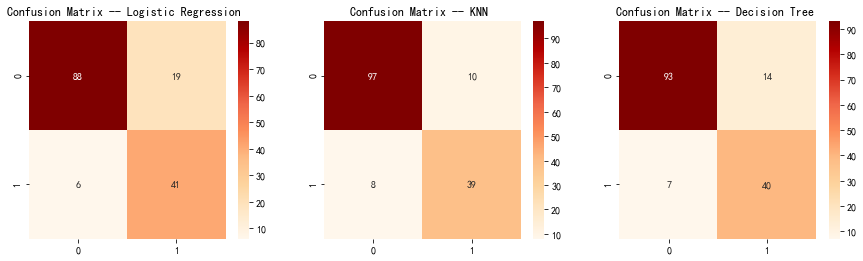

In [43]:
# 绘制逻辑回归，KNN和决策树的混淆矩阵
i=1
fig1= plt.figure(figsize=(3*5,1*4))

estimator_dict={'Logistic Regression':log_gv,'KNN':knn_gv,'Decision Tree':tree_gv}
for key,estimator in estimator_dict.items():
    # 绘制混淆矩阵
    pred_y =  estimator.predict(X_test)
    matrix = pd.DataFrame(confusion_matrix(y_test,pred_y))
    ax1 = fig1.add_subplot(1,3,i)
    sns.heatmap(matrix,annot=True,cmap='OrRd')
    plt.title('Confusion Matrix -- %s ' % key)
    i+=1
plt.show()
#结果表示：三种模型中KNN的准确度最好

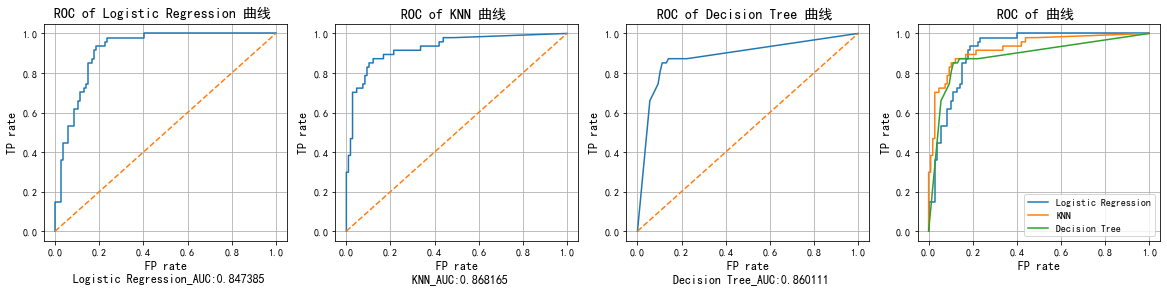

In [44]:
#绘制逻辑回归，KNN和决策树的ROC 曲线并计算AUC 面积
log_score =  log_gv.decision_function(X_test)
knn_score =  knn_gv.predict_proba(X_test)[:,1]
tree_score =  tree_gv.predict_proba(X_test)[:,1]
score = [log_score,knn_score,tree_score]
i=0
j=1
fig2 = plt.figure(figsize=(4*5,1*4))
estimator_dict={'Logistic Regression':log_gv,'KNN':knn_gv,'Decision Tree':tree_gv}
for key,estimator in estimator_dict.items():
    pred_y =  estimator.predict(X_test)
    ax2 = fig2.add_subplot(1,4,j)
    fprs,tprs,thresholds = metrics.roc_curve(y_test,score[i])
    plt.plot(fprs,tprs)
    plt.plot([0,1],linestyle='--')
    area = roc_auc_score(y_test,pred_y)
    plt.xlabel('FP rate\n %s_AUC:%f' % (key,area),fontsize=12)
    plt.ylabel('TP rate',fontsize=12)
    plt.title('ROC of %s 曲线 ' % key,fontsize=14)
    plt.grid()
    i +=1
    j +=1
#将多个曲线汇总在一张图上
    ax3 =  fig2.add_subplot(1,4,4)
    plt.plot(fprs,tprs,label=key)

    plt.xlabel('FP rate' ,fontsize=12)
    plt.ylabel('TP rate',fontsize=12)
    plt.title('ROC of 曲线 ' ,fontsize=14)
        # 添加网格线
    plt.grid()
    plt.legend()
plt.show()
#对比发现knn模型最好